In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline

### Apply a distortion correction to raw images.

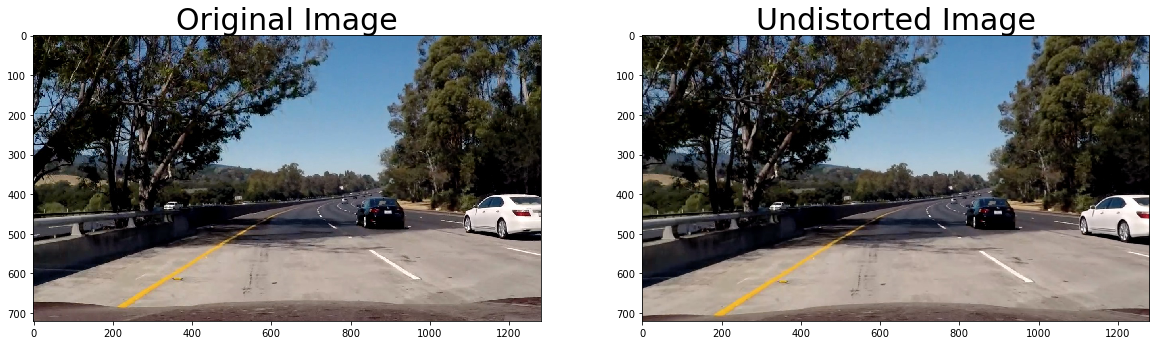

In [2]:
# extract value for camera calibration 
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
img = mpimg.imread('test_images/test5.jpg')
ym_per_pix = 30/720
xm_per_pix = 3.7/700

def undistort(img, mtx, dist) :
    return cv2.undistort(img, mtx, dist, None, mtx)
dst = undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Use color transforms, gradients, etc., to create a thresholded binary image.

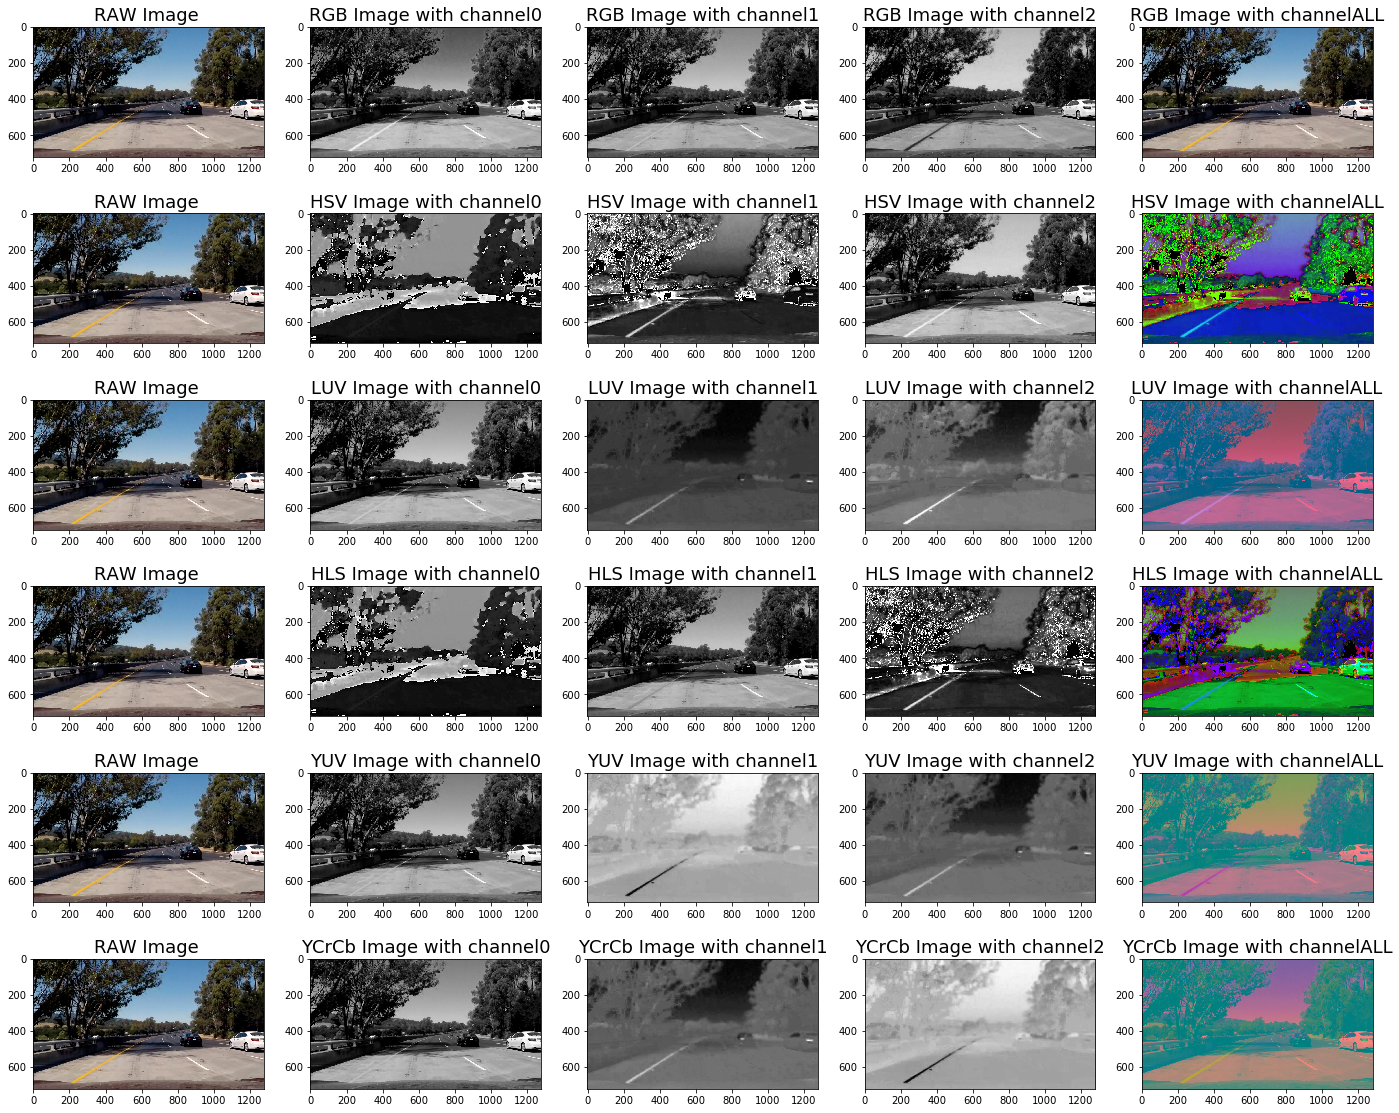

In [3]:
def get_color(image, color_space = 'RGB', channel=0) :
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image) 
        
    if (channel != 'ALL') :
        return feature_image[:,:,channel]
    else :
        return feature_image
    
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
channels = ['RAW', 0, 1, 2, 'ALL']
    
f, axes = plt.subplots(6, 5, figsize=(24, 20))
for i in range(len(color_spaces)) :
    for j in range(len(channels)) :
        if (channels[j] != 'RAW') :
            axes[i,j].imshow(get_color(img, color_space = color_spaces[i], channel=channels[j]), cmap='gray')
            axes[i,j].set_title(color_spaces[i] + ' Image with channel' + str(channels[j]), fontsize=18)
        else :
            axes[i,0].imshow(img)
            axes[i,0].set_title('RAW Image ', fontsize=18)

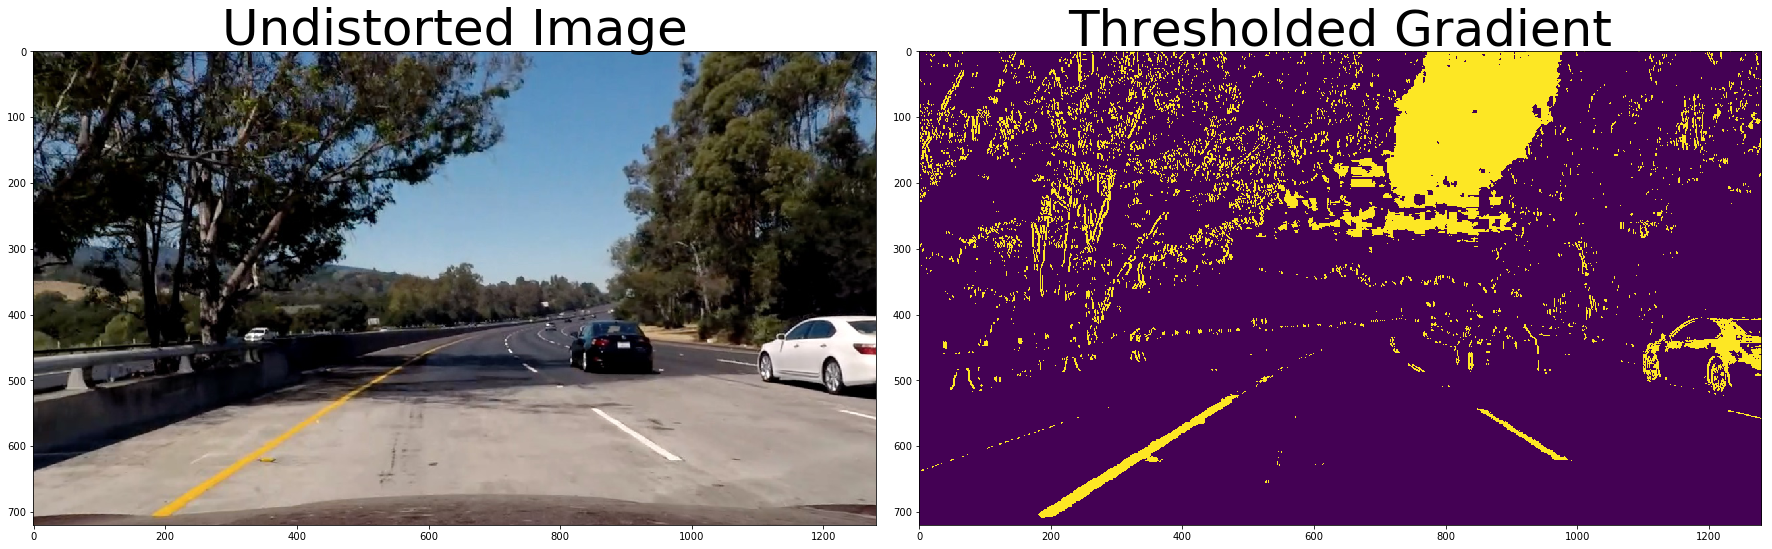

In [4]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):

    # 1) Collect lightness in image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def s_threshold(img, s_thresh=(0, 255)) :
    
    # 1) Collect saturation in image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # 2) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

def l_threshold(img, l_thresh=(0, 255)) :
    
    # 1) Collect lightness in image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    
    # 2) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    return l_binary

# for binarize I use combination of 3 gradients which are lightness, color and sobel of lightness
def binarize(img, s_thresh=(105, 255), sx_thresh=(40, 255),l_thresh=(80,255)):
    
    # Threshold x gradient
    sxbinary = abs_sobel_thresh(img, orient='x', thresh=sx_thresh)
    
    # Threshold saturation channel
    s_binary = s_threshold(img, s_thresh)

    # Threshold lightness
    l_binary = l_threshold(img, l_thresh)
        
    # combine all threshold
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    return  binary
    
# run the function
grad_binary = binarize(dst)
# plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(grad_binary)
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply a perspective transform to rectify binary image ("birds-eye view").

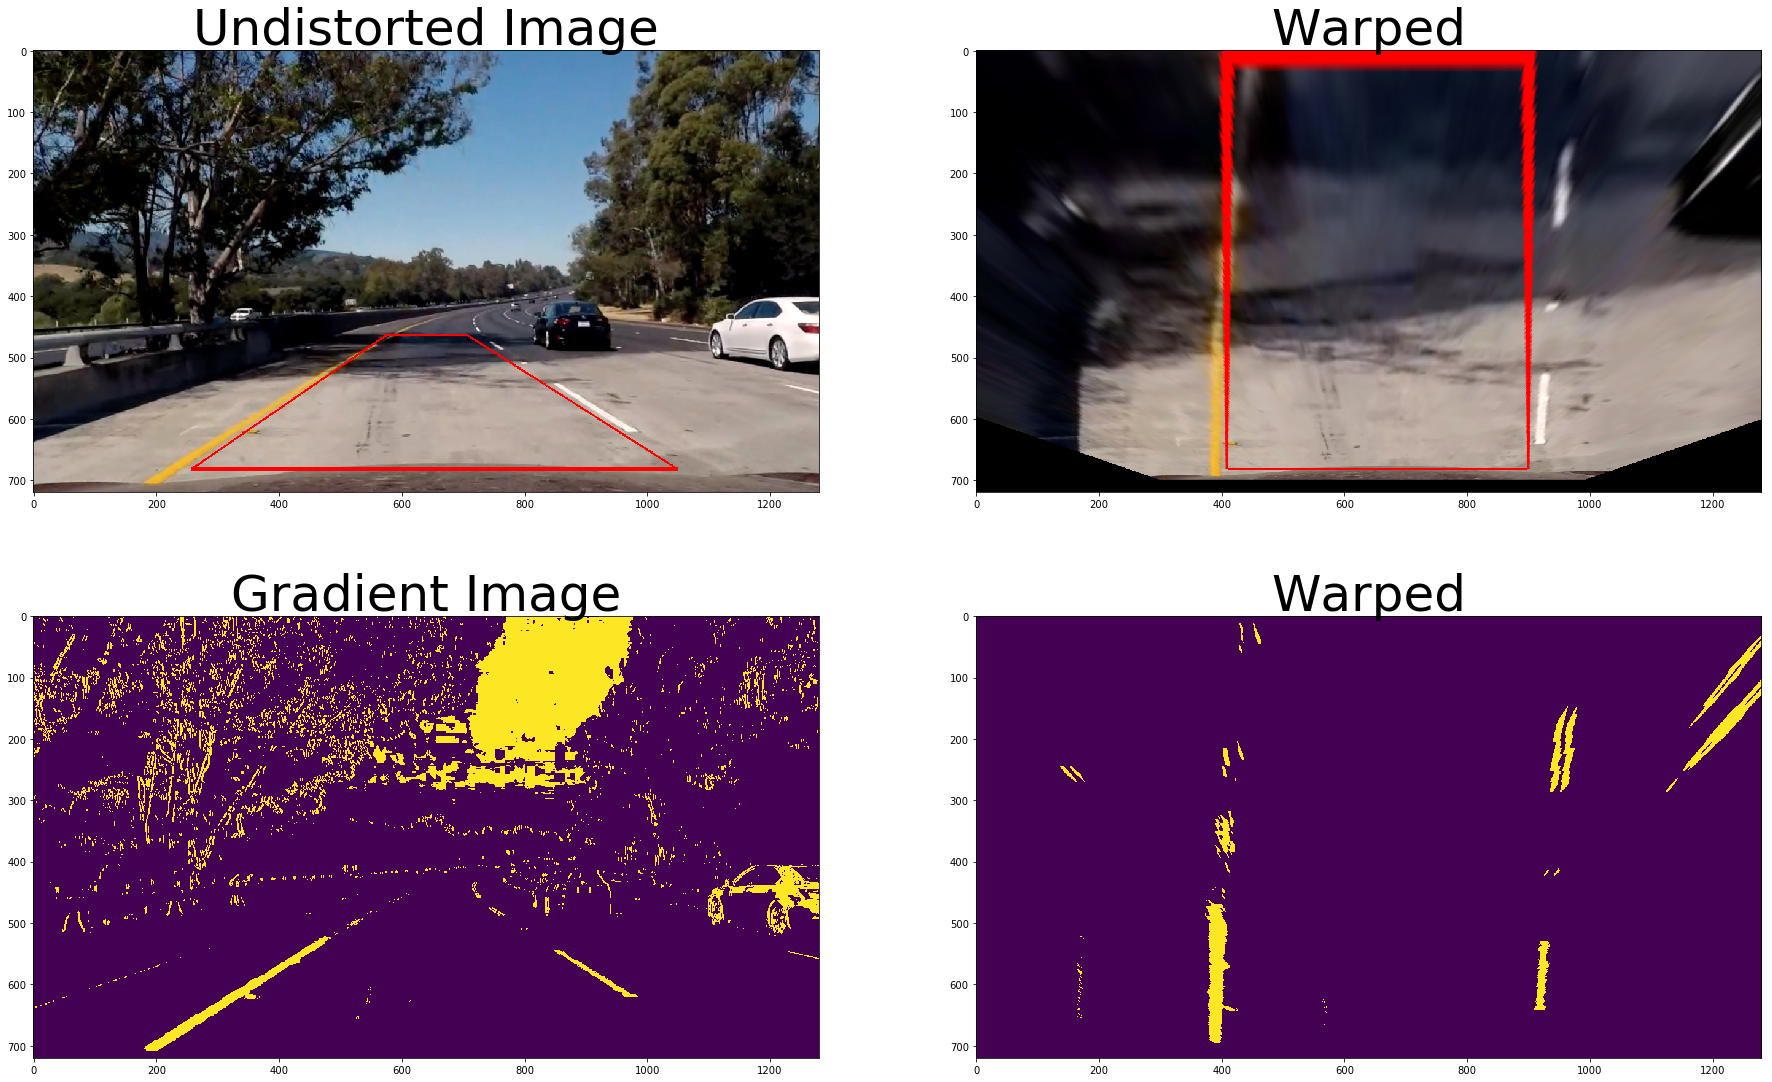

In [5]:
# define corners for given source and destination points
top_left = (575,464)
top_right = (707,464)
bottom_left = (258,682)
bottom_right = (1049,682)

# draw rectangle so we can see is it wrap collectly
drawed = np.copy(dst)
cv2.line(drawed, bottom_left, top_left, color=[255,0,0], thickness=2)
cv2.line(drawed, top_left, top_right, color=[255,0,0], thickness=2)
cv2.line(drawed, top_right, bottom_right, color=[255,0,0], thickness=2)
cv2.line(drawed, bottom_right, bottom_left, color=[255,0,0], thickness=3)

corners = np.float32([bottom_left,top_left,top_right,bottom_right])

def warp(img, corners):
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    # compute the perspective transform, M, given source and destination points
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset, new_top_left+offset, new_top_right-offset, corners[3]-offset])  
    M = cv2.getPerspectiveTransform(src, dst)  
    # compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst,src)
    # warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M, Minv

# run the function
drawed_warped, _, _ = warp(drawed, corners)
binary_warped, perspective_M, Minv = warp(grad_binary, corners)
# plot the result
f, axes = plt.subplots(2, 2, figsize=(24, 16))
axes[0,0].imshow(drawed)
axes[0,0].set_title('Undistorted Image', fontsize=50)
axes[0,1].imshow(drawed_warped)
axes[0,1].set_title('Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
axes[1,0].imshow(grad_binary)
axes[1,0].set_title('Gradient Image', fontsize=50)
axes[1,1].imshow(binary_warped)
axes[1,1].set_title('Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Detect lane pixels and fit to find the lane boundary.

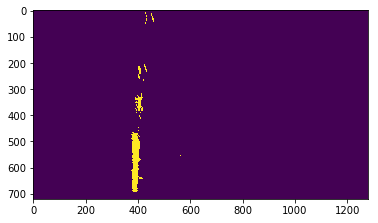

In [6]:
# make mark on binary image to separate left and right lane
# mark for left lane
def left_region_of_interest(img):
    
    # mark vertices
    shape = img.shape
    vertices = np.array([[(180,0),(shape[1]/2,0),(shape[1]/2,0),(6*shape[1]/14,shape[0]),
                      (shape[1]/7+70,shape[0]), (180,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    # defining a 3 channel color to fill the mask with depending on the input image
    ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by vertices with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# run the function
left_binary_warped_roi = left_region_of_interest(binary_warped)
# plot the result
plt.imshow(left_binary_warped_roi)

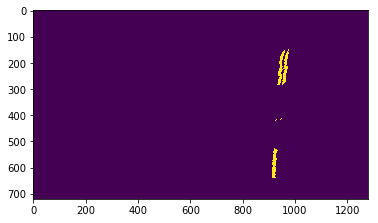

In [7]:
# mark for right lane
def right_region_of_interest(img):
    
    # mark vertices
    shape = img.shape
    vertices = np.array([[(2*shape[1]/3,0),(shape[1]-180,0),(shape[1]-180,0),(6*shape[1]/7-40,shape[0]),
                      (2*shape[1]/3+70,shape[0]), (2*shape[1]/3,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    # defining a 3 channel color to fill the mask with depending on the input image
    ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by vertices with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# run the function
right_binary_warped_roi = right_region_of_interest(binary_warped)
# plot the result
plt.imshow(right_binary_warped_roi)

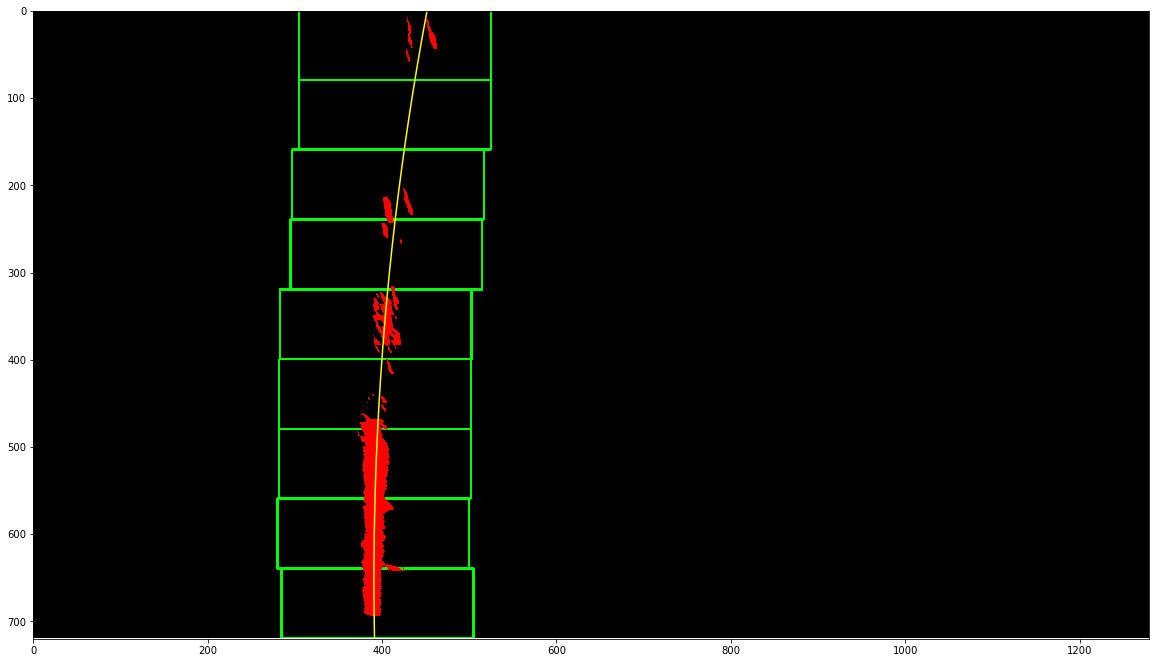

In [8]:
# separate fit polynomial function from class room to left and right and feed them with each lane marked binary image
# left fit polynomial
def left_fit_polynomial(binary_warped, margin=110, minpix=50, is_plot=False) :
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    # plot result
    if is_plot :
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        plt.figure(figsize=(20, 20))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, left_fitx, ploty

# run the function
left_fit, left_fitx, ploty = left_fit_polynomial(left_binary_warped_roi, is_plot=True)

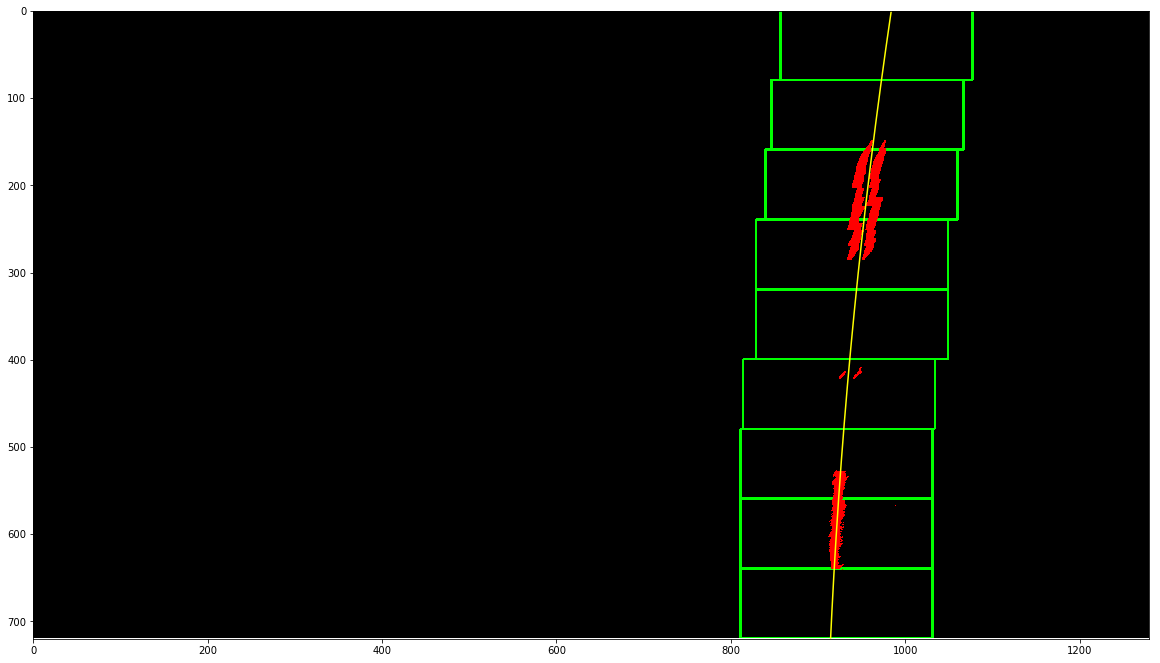

In [9]:
# right fit polynomial
def right_fit_polynomial(binary_warped, margin=110, minpix=50, is_plot=False) :
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # plot result
    if is_plot :
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]
        plt.figure(figsize=(20, 20))
        plt.imshow(out_img)
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return right_fit, right_fitx, ploty

# run the function
right_fit, right_fitx, ploty = right_fit_polynomial(right_binary_warped_roi, is_plot=True)

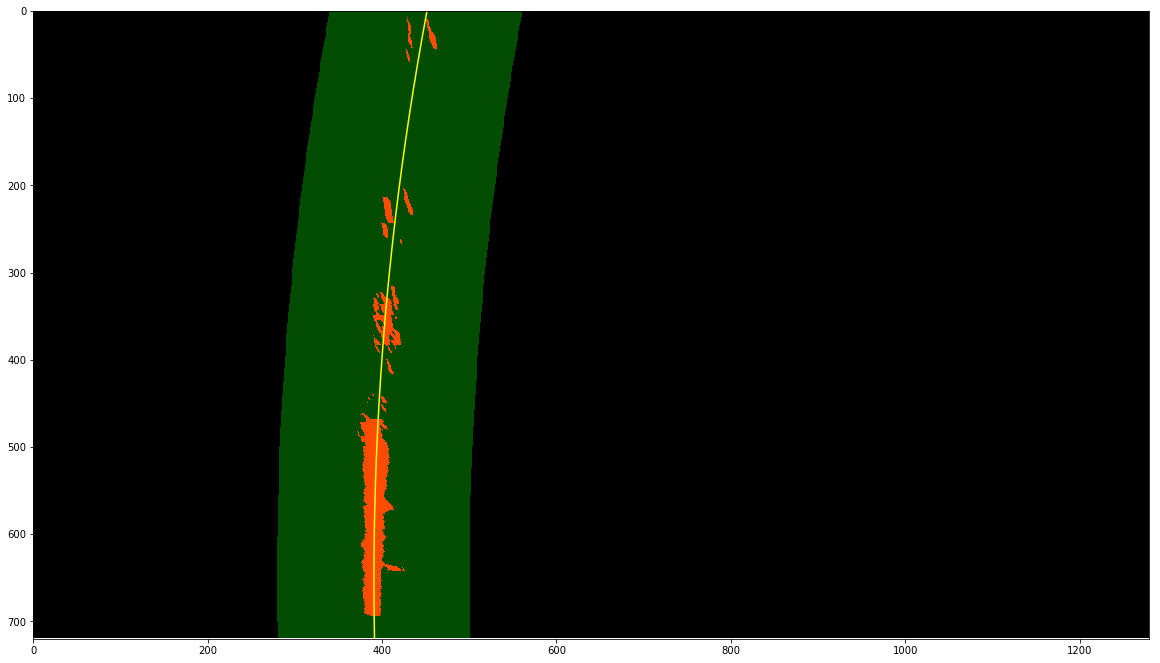

In [10]:
# search lane in margin of old lane, if already have lines use this function
# search in margin for left lane
def left_search_in_margin(binary_warped, left_fit, margin=110, is_plot=False) :
    # from the next frame of video
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    # plot result
    if is_plot : 
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure(figsize=(20, 20))
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fitx, ploty

# run the function
left_fitx, ploty = left_search_in_margin(left_binary_warped_roi, left_fit, is_plot=True)

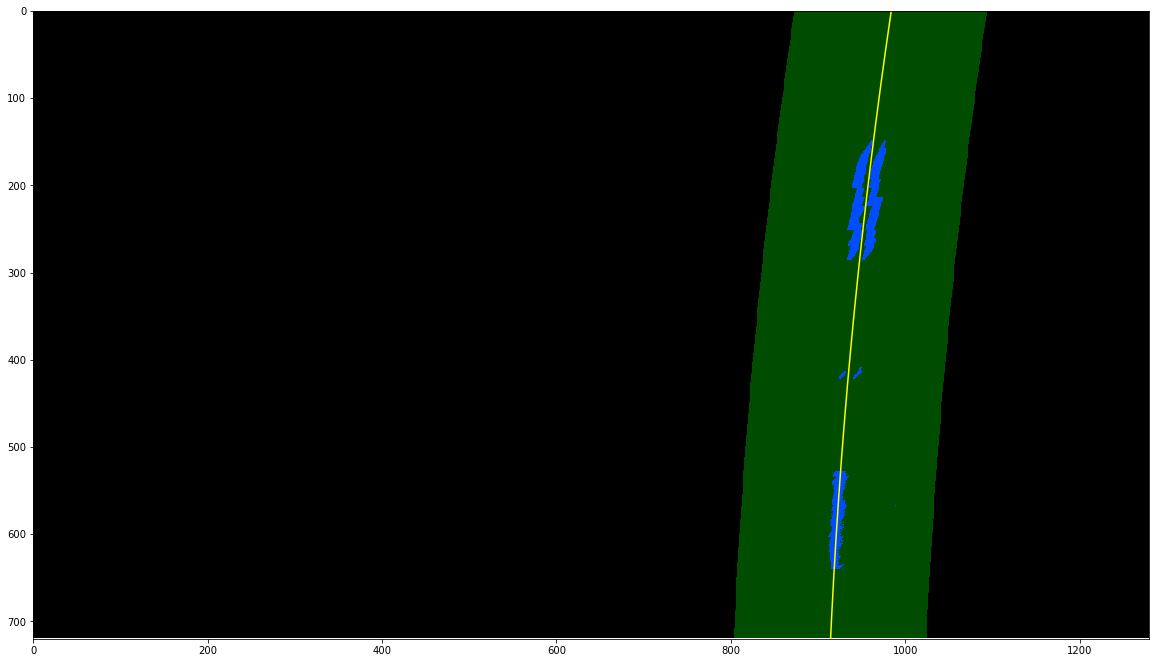

In [11]:
# search in margin for right lane
def right_search_in_margin(binary_warped, right_fit, margin=110, is_plot=False) :
    # from the next frame of video
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # plot result
    if is_plot : 
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure(figsize=(20, 20))
        plt.imshow(result)
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return right_fitx, ploty

# run the function
right_fitx, ploty = right_search_in_margin(right_binary_warped_roi, right_fit, is_plot=True)

### Determine the curvature of the lane and vehicle position with respect to center.

In [12]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# calculate curvature and vehicle position
def get_center_curve(img, left_fitx, right_fitx, xm_per_pix, ym_per_pix) :
    # use beginning of each lane to find center of lane
    lane_width = right_fitx[-1] - left_fitx[-1]
    center_lane = (lane_width)/2 + left_fitx[-1]
    # use center of image as position of the vehicle position
    center_car = img.shape[1]/2
    # calculate vehicle position respect to center of lane
    xm_per_pix = 3.7 / lane_width
    center_diff = (center_car - center_lane) * xm_per_pix

    # calculate curvature using equation in classroom
    ploty = np.linspace(0, 719, num=720)
    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(ploty, left_fitx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, right_fitx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Fit new polynomials to x,y in world space
    left_fix_meter = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fix_meter = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fix_meter[0]*y_eval* ym_per_pix + left_fix_meter[1])**2)**1.5) / np.absolute(2*left_fix_meter[0])
    right_curverad = ((1 + (2*right_fix_meter[0]*y_eval* ym_per_pix + right_fix_meter[1])**2)**1.5) / np.absolute(2*right_fix_meter[0])
    
    return center_diff, left_curverad, right_curverad

# run the function
center_diff, left_curverad, right_curverad = get_center_curve(img, left_fitx, right_fitx, xm_per_pix, ym_per_pix)
print(center_diff)
print(left_curverad, right_curverad)
print(left_curverad / right_curverad)

-0.0910965631271
858.397199391 1750.01888412
0.490507392338


### Warp the detected lane boundaries back onto the original image and display the lane boundaries and numerical estimation of lane curvature and vehicle position.

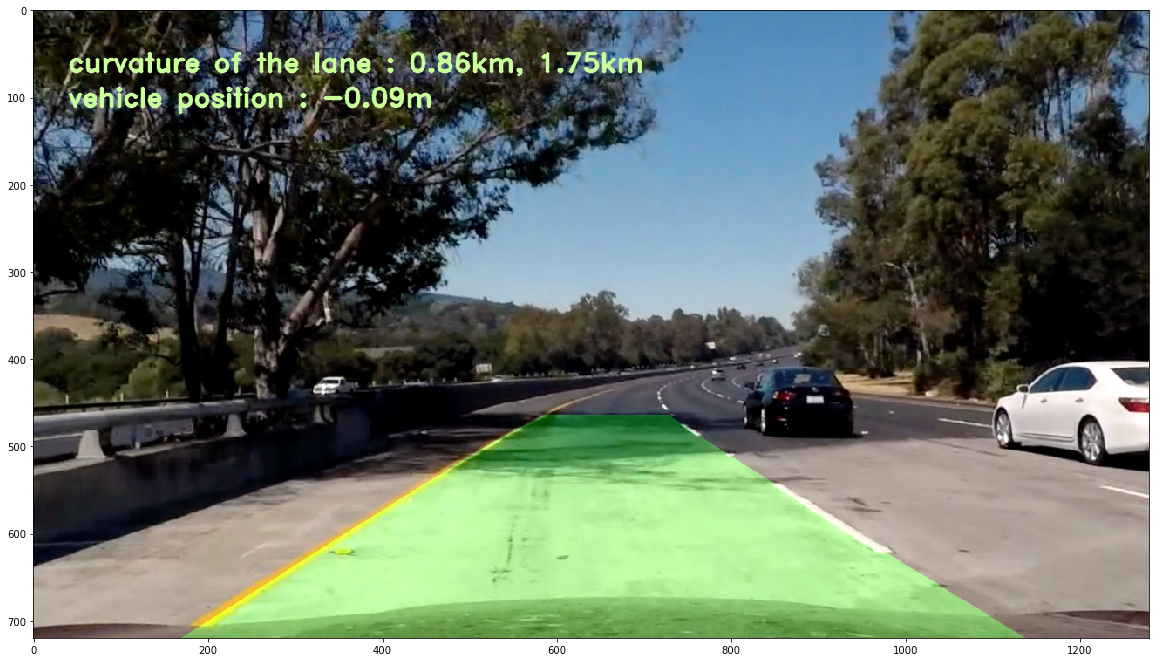

In [13]:
# put result on original image
def output(img, left_fitx, right_fitx, ploty, center_diff, left_curverad, right_curverad, Minv) :
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero[:,:,0], warp_zero[:,:,1], warp_zero[:,:,2]))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    new_img = np.copy(result)
    font = cv2.FONT_HERSHEY_DUPLEX
    text_curvature = "curvature of the lane : {0:.2f}km, {1:.2f}km".format(left_curverad/1000,right_curverad/1000)
    cv2.putText(new_img, text_curvature, (40,70), font, 1, (200,255,155), 2, cv2.LINE_AA)
    text_vehicle = "vehicle position : {0:.2f}m".format(center_diff)
    cv2.putText(new_img, text_vehicle, (40,110), font, 1, (200,255,155), 2, cv2.LINE_AA)
    return new_img

# run the function
result = output(dst, left_fitx, right_fitx, ploty, center_diff, left_curverad, right_curverad, Minv) 
# show result
plt.figure(figsize=(20, 12))
plt.imshow(result)

### combine all functions

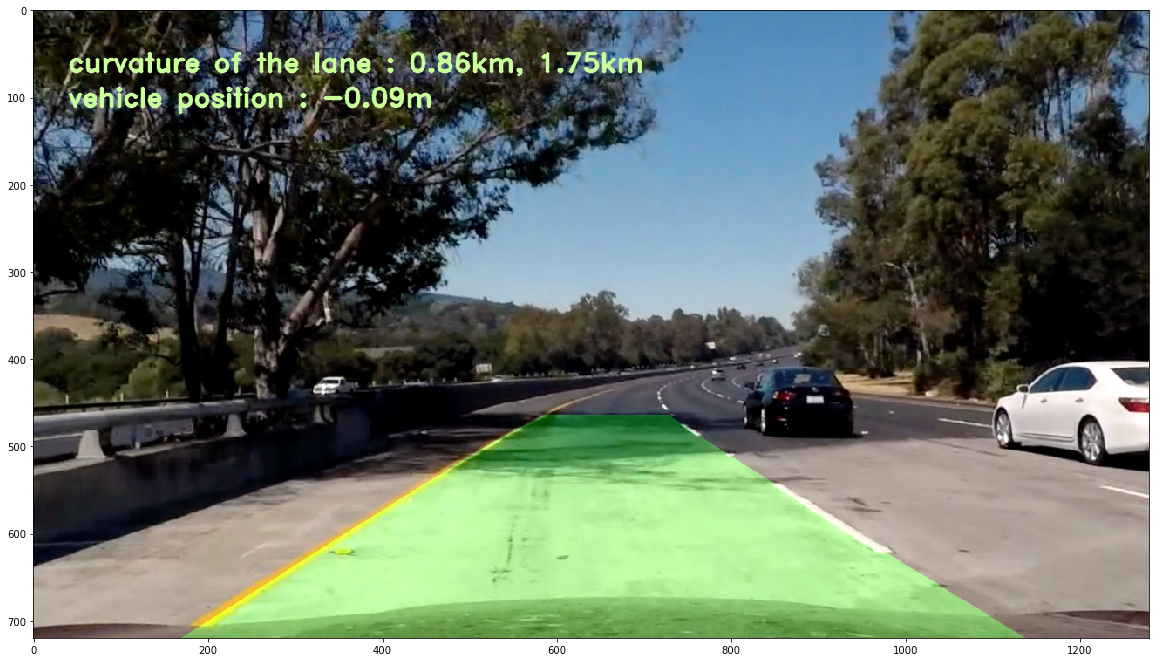

In [14]:
left_fit = None
right_fit = None

def pipeline(img, left_fit, right_fit) :
    
    with open('camera_dist_pickle.p', mode='rb') as f:
        dist_pickle = pickle.load(f)
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]

    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    
    corners = np.float32([bottom_left,top_left,top_right,bottom_right])
    
    dst = undistort(img, mtx, dist)
    binary = binarize(dst)
    binary_warped, perspective_M, Minv = warp(binary, corners)
    left_binary_warped_roi = left_region_of_interest(binary_warped)
    right_binary_warped_roi = right_region_of_interest(binary_warped)
    if (left_fit is not None and right_fit is not None) :
        left_fitx, ploty = left_search_in_margin(left_binary_warped_roi, left_fit)
        right_fitx, ploty = right_search_in_margin(right_binary_warped_roi, right_fit)
    else :
        left_fit, left_fitx, ploty = left_fit_polynomial(left_binary_warped_roi)
        right_fit, right_fitx, ploty = right_fit_polynomial(right_binary_warped_roi)
    center_diff, left_curverad, right_curverad = get_center_curve(dst, left_fitx, right_fitx, xm_per_pix, ym_per_pix)
    result = output(dst, left_fitx, right_fitx, ploty, center_diff, left_curverad, right_curverad, Minv) 

    return result, left_fit, right_fit

result, left_fit, right_fit = pipeline(img, left_fit, right_fit)
plt.figure(figsize=(20, 12))
plt.imshow(result)

In [15]:
from moviepy.editor import VideoFileClip

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.fit = None

def videoPipeline(inputPath, outputPath):
    
    leftLane = Line()
    rightLane = Line()
    
    def process_image(img) :
        
        left_fit = leftLane.fit
        right_fit = rightLane.fit
        result, left_fit, right_fit = pipeline(img, left_fit, right_fit)
        leftLane.fit = left_fit
        rightLane.fit = right_fit
        fitted = True
        return result
    
    video = VideoFileClip(inputPath)
    clip = video.fl_image(process_image)
    clip.write_videofile(outputPath, audio=False)
        
        
videoPipeline('project_video.mp4', 'project_video_output.mp4')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:48<00:00,  7.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

